## Avaliação final - Aprendizado Dinâmico


Profa. **Cibele Russo**

**MBA em Ciências de Dados**

**Atenção: Você deve resolver as questões neste notebook e submetê-lo inteiramente executado no moodle.**


O estado do Amazonas foi fortemente afetado pela pandemia de COVID-19. Os dados de 2021 de casos confirmados e mortes diárias nesse estado estão disponíveis no arquivo covidAM.csv. Nessa avaliação, trabalharemos com os dados **confirmados** (confirmed).

1. Faça a leitura dos dados, estabeleça um índice por datas. Caso haja dados faltantes, complete os dados como indicado. Faça a visualização dos dados com gráfico de linhas e boxplots por semanas. Há evidências de estacionariedade nos gráficos? Por quê?


2. Proponha uma decomposição dos dados confirmados em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.


3. Divida a série de registros confirmados em treinamento e teste, com 30 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos? 


4. Utilizando a base de treinamento de registros confirmados de COVID-19, obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido (auto_arima), para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
    
    - As previsões com um modelo de redes neurais recorrentes (LSTM ou GRU).    
    
    

5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Escolha o método que produz as melhores previsões. Justifique sua resposta. Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.


#### Boa prova!

## Item 1

1. Faça a leitura dos dados, estabeleça um índice por datas. Caso haja dados faltantes, complete os dados como indicado. Faça a visualização dos dados com gráfico de linhas e boxplots por semanas. Há evidências de estacionariedade nos gráficos? Por quê?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

pkgdir = '/hdd/MBA/AprendizadoDinamico/Data'

plt.rcParams['figure.figsize'] = [12,6]

# Ignorar warnings não prejudiciais
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('covidAM.csv', index_col=0, parse_dates=True)
idx = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(idx)
df.fillna(method='ffill', inplace=True)

In [3]:
df.head()

,confirmed,deaths
2021-01-02,293,30
2021-01-03,546,20
2021-01-04,559,23
2021-01-05,1928,46
2021-01-06,2192,86


<AxesSubplot:>

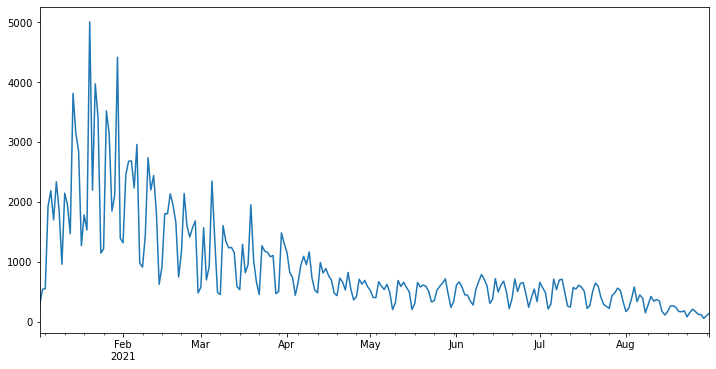

In [4]:
df.confirmed.plot()

<AxesSubplot:ylabel='confirmed'>

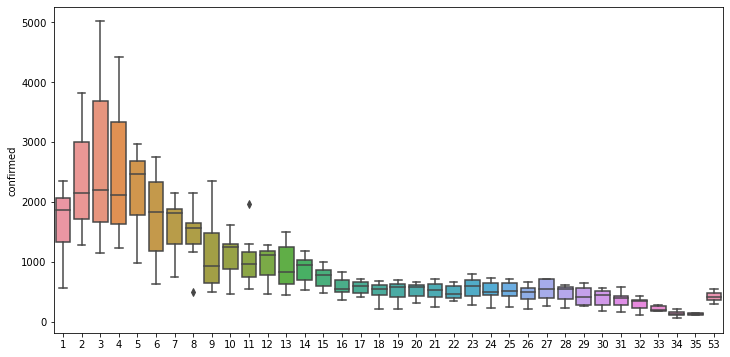

In [5]:
import seaborn as sns

sns.boxplot(data=df, y='confirmed', x=df.index.week)

<AxesSubplot:>

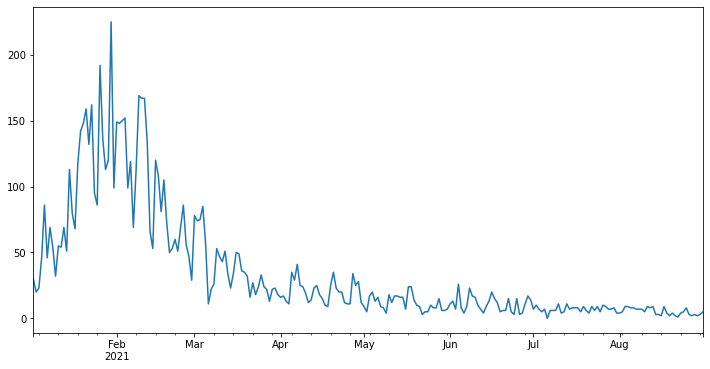

In [6]:
df.deaths.plot()

<AxesSubplot:ylabel='deaths'>

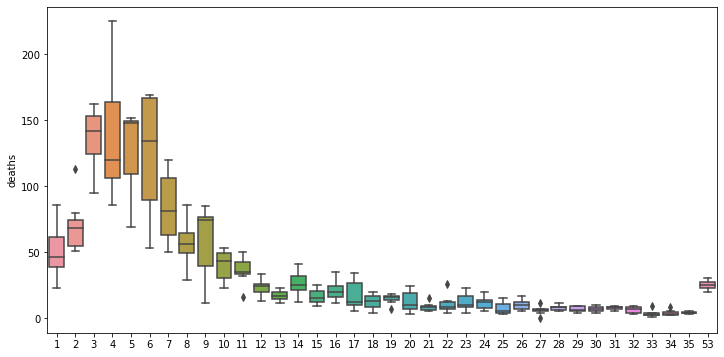

In [7]:
import seaborn as sns

sns.boxplot(data=df, y='deaths', x=df.index.week)

**Resposta item 1**




No período todo analisado nos gráficos de "deaths" e "confirmed" as series não são estacionárias, pois não apresentam uma média constante durante o tempo. No entando, olhando para as ultimas semanas dos gráficos, existe uma tendência das séries se tornarem estacionárias.

## Item 2

2. Proponha uma decomposição dos dados confirmados em tendência e sazonalidade. Comente as componentes de tendência, sazonalidade e resíduos. Obtenha os gráficos de autocorrelação e autocorrelação parcial. Esses resultados indicam a presença de autocorrelação? Justifique.


**Resposta item 2**




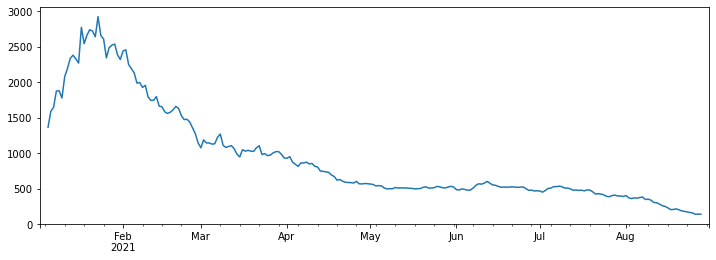

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['confirmed'],model='multiplicative')
result.trend.plot(figsize=(12,4));

A componente de tendência indica que os dados vão tendendo a zero, ou seja, mostra que casos confirmados estão diminuindo. 

<AxesSubplot:>

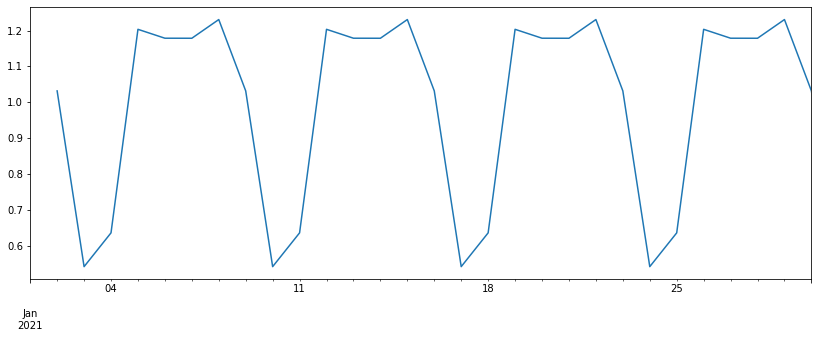

In [9]:
result.seasonal.plot(figsize=(14,5),xlim=['2021-01-01','2021-01-30'])

Pelo gráfico acima temos uma componente sazonal de período de 7, ou seja, a cada semana o comportamento se repete. 

<AxesSubplot:>

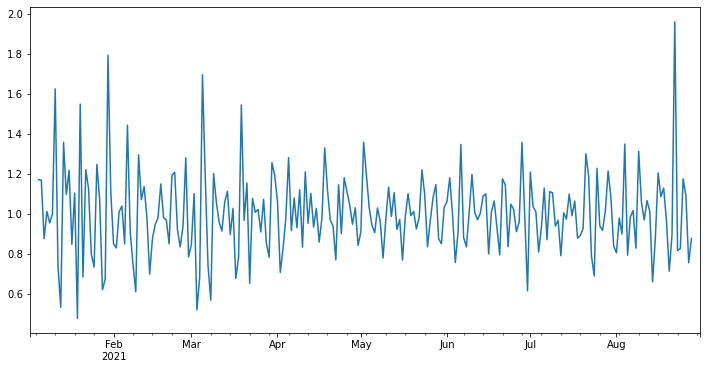

In [10]:
result.resid.plot()

Pelo gráfico temos que os resíduos estão em torno de 1

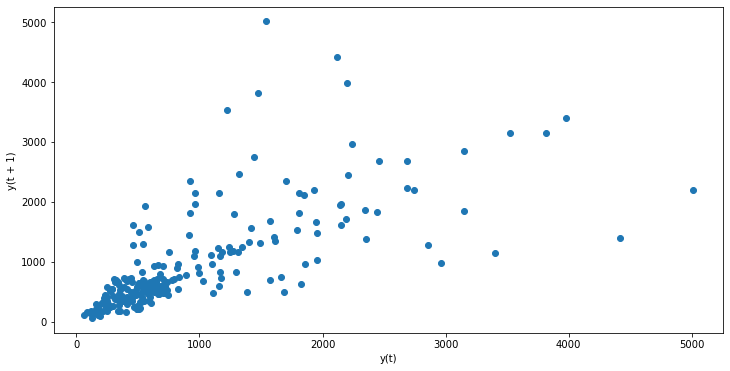

In [11]:
from pandas.plotting import lag_plot

lag_plot(df['confirmed'],lag=1);

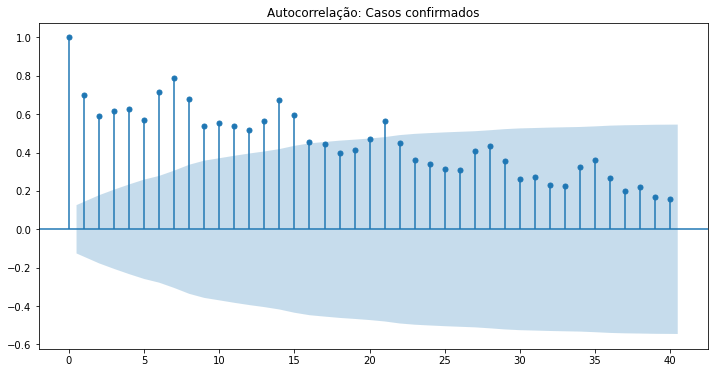

In [12]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
title = 'Autocorrelação: Casos confirmados'
lags = 40
plot_acf(df['confirmed'],title=title,lags=lags);

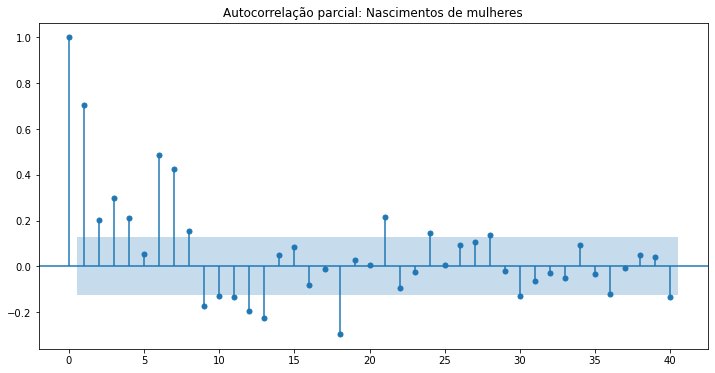

In [13]:
title='Autocorrelação parcial: Nascimentos de mulheres'
lags=40
plot_pacf(df['confirmed'],title=title,lags=lags);

Tanto pelo gráfico de autocorrelação quando o de autocorrelação parcial tem-se pontos para lag>0 com correlação maior que 0.6 e que ultrapassam o intervalo de confiança. Isso significa que existe uma correlação significativa entre a série e os primeiros lags dela. 

## Item 3

3. Divida a série de registros confirmados em treinamento e teste, com 30 observações na base de teste. A que se referem os dados de treinamento e teste e como essa divisão contribui para a análise de modelos preditivos? 

**Resposta item 3**




In [14]:
len(df)

242

In [15]:
242-30

212

In [16]:
dfcon=df['confirmed'].copy()

treino=dfcon.iloc[0:212]
teste=dfcon.iloc[212:]

<AxesSubplot:>

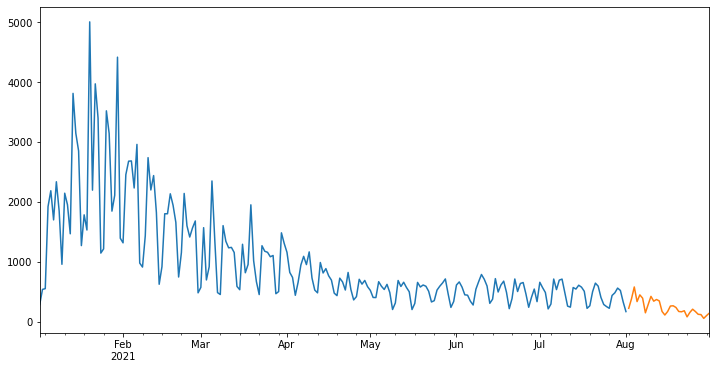

In [17]:
treino.plot()
teste.plot()

Os dados de treinamento são utilizado para ajustar os parametros dos modelos. Com o modelo treinado é possível fazer previsões dos dados em tempos futuros. Os dados de teste servem para comparar com as previsões e verificar o quanto estão próximos. 

## Item 4


4. Utilizando a base de treinamento de registros confirmados de COVID-19, obtenha:

    - As previsões de Holt Winters.
    
    - As previsões obtidas pelo melhor modelo SARIMA, com ordens selecionadas segundo critério preestabelecido (auto_arima), para a variável confirmed. Identifique a natureza das componentes desse melhor modelo (por exemplo, “o modelo componentes autorregressiva não sazonal, componente de médias móveis sazonal", etc).
    
    - As previsões com o método Theta usual.
          
    - As previsões com um modelo de redes neurais recorrentes (LSTM ou GRU).    
    
    

### Holt Winters

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

modelo = ExponentialSmoothing(treino,trend='add',seasonal='mul',seasonal_periods=7)

ajustado_HW=modelo.fit()
 
preditohw = ajustado_HW.forecast(30).rename('Previsão Holt-Winters')

C:\Users\nasse\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot:>

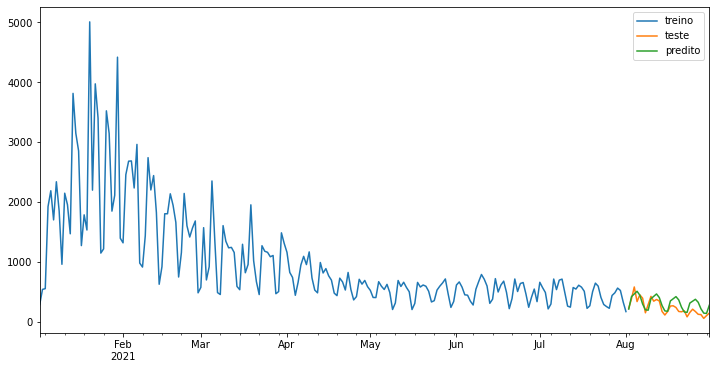

In [19]:
treino.plot(legend=True,label='treino')
teste.plot(legend=True,label='teste')
preditohw.plot(legend=True,label='predito')

### SARIMA

In [20]:
# Determindo melhor modelo
from pmdarima import auto_arima 

stepwise_fit = auto_arima(df['confirmed'],
                          m=7,
                          seasonal=True,
                          #trace=True,
                          error_action='ignore',   
                          suppress_warnings=True,  
                          stepwise=True)           

stepwise_fit.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  242
Model:             SARIMAX(2, 1, 2)x(2, 0, 2, 7)   Log Likelihood               -1779.588
Date:                           Mon, 13 Sep 2021   AIC                           3577.176
Time:                                   20:21:50   BIC                           3608.539
Sample:                                        0   HQIC                          3589.812
                                           - 242                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7363      0.049     14.902      0.000       0.639       0.833
ar.L2          0.0554      0.046      1.206      0.228      -0.035       0.145
ma.L1         -1.8398      0.051    -35.737      0.000      -1.941      -1.739
ma.L2          0.9159      0.047     19.617      0.000       0.824       1.007
ar.S.L7        0.1678      0.131      1.278      0.201      -0.090       0.425
ar.S.L14       0.7942      0.127      6.256      0.000       0.545       1.043
ma.S.L7        0.1382      0.148      0.932      0.351      -0.152       0.429
ma.S.L14      -0.7211      0.123     -5.854      0.000      -0.962      -0.480
sigma2      1.477e+05   1.13e+04     13.033      0.000    1.25e+05     1.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):               344.62
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                            -0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

O melhor modelo encontrado pelo auto arima é o **SARIMAX(2, 1, 2)x(2, 0, 2, 7)**. Com componente autorregressiva p=2, componante integrado d=1, componente de médias móveis q=2 e componentes sazonais P=2, D=0, Q=2 e periodo 7.

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
modelo = SARIMAX(treino,order=(2,1,2),seasonal_order=(2, 0, 2, 7))
resultado = modelo.fit()
#resultado.summary()

C:\Users\nasse\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# Obtain predicted values
inicio=len(treino)
fim=len(treino)+len(teste)-1
preditosar = resultado.predict(start=inicio, end=fim, dynamic=False, typ='levels').rename('Previsões SARIMA(0,1,1)(1,0,1,7) ')
preditosar.index = teste.index

<AxesSubplot:>

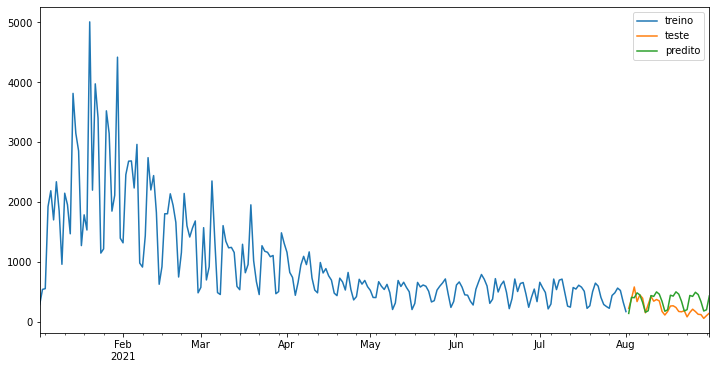

In [23]:
treino.plot(legend=True,label='treino')
teste.plot(legend=True,label='teste')
preditosar.plot(legend=True,label='predito')

### Theta usual

In [24]:
from statsmodels.tsa.forecasting.theta import ThetaModel
tm = ThetaModel(treino)
res = tm.fit()
print(res.summary())

                              ThetaModel Results                              
Dep. Variable:              confirmed   No. Observations:                  212
Method:                       OLS/SES   Deseasonalized:                   True
Date:                Mon, 13 Sep 2021   Deseas. Method:         Multiplicative
Time:                        20:21:51   Period:                              7
Sample:                    01-02-2021                                         
                         - 08-01-2021                                         
   Parameter Estimates   
           Parameters    
-------------------------
b0     -9.319733648465618
alpha 0.29338840725280385
-------------------------


In [25]:
res = ThetaModel(treino,deseasonalize=True,period=7).fit()
preditothe = res.forecast(30)

<AxesSubplot:>

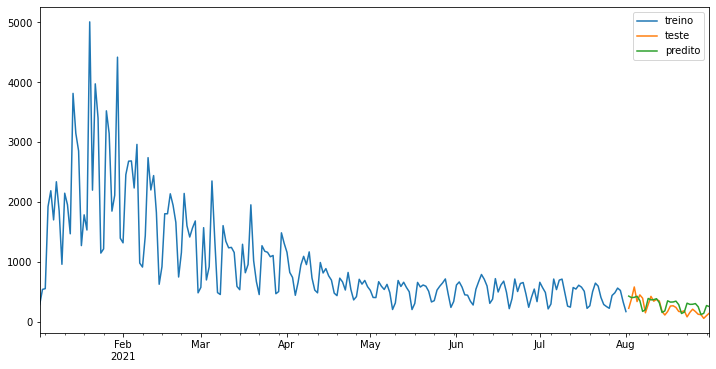

In [26]:
treino.plot(legend=True,label='treino')
teste.plot(legend=True,label='teste')
preditothe.plot(legend=True,label='predito')

### Redes neurais recorrentes (LSTM ou GRU)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [28]:
train=dfcon.iloc[0:212].to_frame()
test=dfcon.iloc[212:].to_frame()

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [30]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# defina o gerador
n_input = 7
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [31]:
# Qual é a aparência do primeiro lote?
X,y = generator[0]
print(f'Dado o array: \n{X.flatten()}');
print(f'Previsão: \n {y}');

Dado o array: 
[0.02420857 0.076557  ]
Previsão: 
 [[0.07924684]]


In [33]:
# Modelo com 4 camadas 
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(4))
model.add(Dense(4))
model.add(Dense(1,activation='linear'))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5         
Total params: 41,229
Trainable params: 41,229
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Ajuste do modelo

model.fit_generator(generator,epochs=100)

Epoch 1/100
205/205 [==============================] - 2s 3ms/step - loss: 0.0203
Epoch 2/100
205/205 [==============================] - 1s 4ms/step - loss: 0.0127
Epoch 3/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0129
Epoch 4/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0116
Epoch 5/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0114
Epoch 6/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0132
Epoch 7/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0115
Epoch 8/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0118
Epoch 9/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0110
Epoch 10/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0115
Epoch 11/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0103
Epoch 12/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0099
Epoch 13/100


205/205 [==============================] - 1s 3ms/step - loss: 0.0055
Epoch 100/100
205/205 [==============================] - 1s 3ms/step - loss: 0.0063


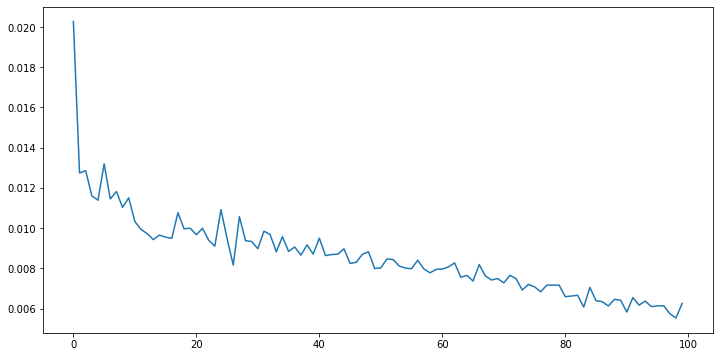

In [35]:
model.history.history.keys()
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [36]:
first_eval_batch = scaled_train[-7:]


In [37]:
# Agora vamos considerar as previsões para as próximas 30 observações e comparar com a base de teste

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # obter a previsão de tempo 1 antecipadamente ([0] é para pegar apenas o número em vez de [array])
    current_pred = model.predict(current_batch)[0]
    
    # predição
    test_predictions.append(current_pred) 
    
    # atualize a rodada para agora incluir a previsão e descartar o primeiro valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [38]:
test_predictions

[array([0.01155706], dtype=float32),
 array([0.05044555], dtype=float32),
 array([0.0694201], dtype=float32),
 array([0.07475543], dtype=float32),
 array([0.0640534], dtype=float32),
 array([0.02613765], dtype=float32),
 array([-0.00259656], dtype=float32),
 array([0.01166], dtype=float32),
 array([0.04972727], dtype=float32),
 array([0.07058118], dtype=float32),
 array([0.07212222], dtype=float32),
 array([0.05812851], dtype=float32),
 array([0.01950386], dtype=float32),
 array([-0.00447954], dtype=float32),
 array([0.01275675], dtype=float32),
 array([0.05070293], dtype=float32),
 array([0.06994177], dtype=float32),
 array([0.06944001], dtype=float32),
 array([0.05252567], dtype=float32),
 array([0.01358943], dtype=float32),
 array([-0.00560381], dtype=float32),
 array([0.01499139], dtype=float32),
 array([0.05255365], dtype=float32),
 array([0.06912023], dtype=float32),
 array([0.06702988], dtype=float32),
 array([0.04663601], dtype=float32),
 array([0.00831269], dtype=float32),
 ar

In [39]:
scaled_test

array([[ 0.0113801 ],
       [ 0.04427892],
       [ 0.08504035],
       [ 0.03455411],
       [ 0.05772812],
       [ 0.04634802],
       [-0.00413822],
       [ 0.02441548],
       [ 0.05255535],
       [ 0.03600248],
       [ 0.04179599],
       [ 0.03683013],
       [ 0.00041382],
       [-0.01179392],
       [ 0.00020691],
       [ 0.01924271],
       [ 0.02007035],
       [ 0.01427685],
       [ 0.00041382],
       [-0.00062073],
       [ 0.00289675],
       [-0.01820815],
       [-0.00289675],
       [ 0.00827643],
       [ 0.00020691],
       [-0.00931099],
       [-0.01034554],
       [-0.02338092],
       [-0.01386303],
       [-0.00517277]])

In [40]:
preditorede = scaler.inverse_transform(test_predictions)


In [41]:
test['predito']=preditorede

In [42]:
test.head()

,confirmed,predito
2021-08-02,231,231.855295
2021-08-03,390,419.803357
2021-08-04,587,511.507340
2021-08-05,343,537.292994
2021-08-06,455,485.570089


<AxesSubplot:>

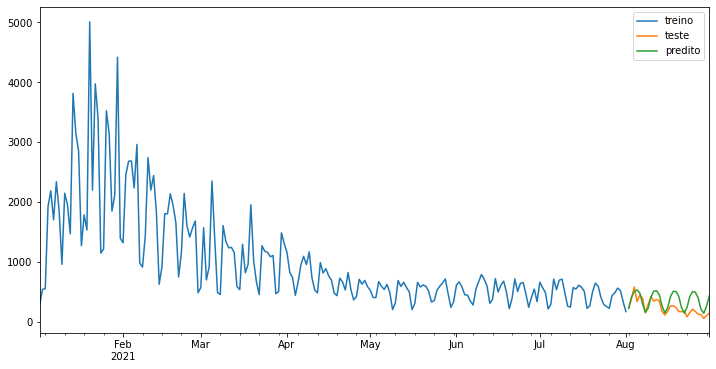

In [43]:
train['confirmed'].plot(legend=True,label='treino')
test['confirmed'].plot(legend=True,label='teste')
test['predito'].plot(legend=True,label='predito')

## Item 5


5. Utilize o erro absoluto médio para comparar as previsões obtidas com as observações da base de teste. Qual o método que produz as melhores previsões? Represente em um mesmo gráfico a base de treinamento, de teste e as previsões obtidas pelos quatro métodos.


In [44]:
from sklearn.metrics import mean_absolute_error

error = mean_absolute_error(teste, preditohw)
error2 = mean_absolute_error(teste, preditosar)
error3 = mean_absolute_error(teste, preditothe)
error4 = mean_absolute_error(test['confirmed'], test['predito'])
print(f'HOLT-WINTERS: {error:11.10}')
print(f'SARIMA: {error2:11.10}')
print(f'THETA: {error3:11.10}')
print(f'REDE NEURAL: {error4:11.10}')

HOLT-WINTERS: 93.98165511
SARIMA: 142.3447488
THETA: 93.57454524
REDE NEURAL: 135.7340586


In [45]:
from statsmodels.tools.eval_measures import rmse

error = rmse(teste, preditohw)
error2 = rmse(teste, preditosar)
error3 = rmse(teste, preditothe)
error4 = rmse(test['confirmed'], test['predito'])
print(f'HOLT-WINTERS: {error:11.10}')
print(f'SARIMA: {error2:11.10}')
print(f'THETA: {error3:11.10}')
print(f'REDE NEURAL: {error4:11.10}')

HOLT-WINTERS: 109.8828812
SARIMA: 172.3743981
THETA: 113.0696397
REDE NEURAL: 167.1823823


**Resposta**:
    
    Pela métrica do erro absoluto médio tem-se que o modelo Theta apresenta o menor erro. No entando considerando o erro absoluto médio e o erro quadrático médio tem-se que o modelo de Holt-Windter apresenta melhores previsões.

In [46]:
test.index.max()

Timestamp('2021-08-31 00:00:00', freq='D')

<AxesSubplot:>

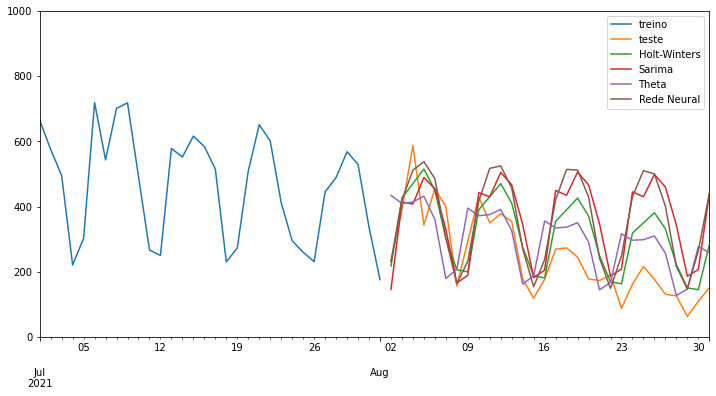

In [47]:
train['confirmed'].plot(legend=True,label='treino',xlim=['2021-07-01','2021-08-31'],ylim=[0,1000])
test['confirmed'].plot(legend=True,label='teste',xlim=['2021-07-01','2021-08-31'])
preditohw.plot(legend=True,label='Holt-Winters',xlim=['2021-07-01','2021-08-31'])
preditosar.plot(legend=True,label='Sarima',xlim=['2021-07-01','2021-08-31'])
preditothe.plot(legend=True,label='Theta',xlim=['2021-07-01','2021-08-31'])
test['predito'].plot(legend=True,label='Rede Neural',xlim=['2021-07-01','2021-08-31'])